In [1]:
%pip install langchain_anthropic langchain_openai langchain_ollama langchain_community


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from typing import Annotated, Literal

from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import InjectedToolCallId, tool
from langchain_core.messages import BaseMessage, ToolMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command, interrupt


In [3]:
def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [4]:
def make_trainer_system_prompt() -> str:
    return (
        "あなたはソフトウェアエンジニアの面接官です。"
        "提供されたツールを使用して、候補者が採用要件に合うか面接をしましょう。"
        "質問は合計3回行ってください。技術的な質問やソフトスキルの質問をしてください。"
        "質問に対する回答に対して、深ぼった質問もしてください。"
        "質問が終わったら合否を判断して、応答の先頭に「FINAL ANSWER」と付けてください。"
    )

In [5]:
def make_trainee_system_prompt() -> str:
    return (
        "あなたはシニアのソフトウェアエンジニアのポジションに応募している候補者です"
        "質問に対して自身の開発経験の具体的なエピソードを交えて回答してください。"
    )

In [6]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    ask_human: bool

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = ChatAnthropic(
    model="claude-3-5-haiku-20241022",
    temperature=0.2,
)
# llm = ChatOpenAI(model="gpt-4o-mini")
# llm = ChatOllama(
#     model="qwen3", # model="llama3.2",
#     temperature=0.2,
# )

trainee_agent = create_react_agent(
    llm,
    tools=tools,
    prompt=make_trainee_system_prompt(),
)

In [7]:
def human_node(state: MessagesState):
    """Human trainer node - uses interrupt to wait for human input"""
    print("👨‍💼 人間の質問を待機中...")
    
    # Check if last message is from human (new question)
    if state["messages"]:
        last_message = state["messages"][-1]
        print(f"📝 最後のメッセージ: {last_message.content[:50]}...")
        print(f"📝 メッセージタイプ: {type(last_message)}")
        print(f"📝 メッセージのname属性: {getattr(last_message, 'name', 'None')}")
        
        # If it's a human message with actual question content, proceed to trainee
        if (hasattr(last_message, 'name') and last_message.name == "human" and 
            "面接を開始します" not in last_message.content):
            print("✅ 人間からの質問を検出、AI候補者に転送中...")
            if "FINAL ANSWER" in last_message.content:
                print("🏁 面接終了")
                return
            # Don't return anything, let the flow continue naturally
        else:
            print("⏸️ 人間からの入力を待機中...")
    
    # Use interrupt to wait for human input
    user_input = interrupt("👤 あなたの質問を入力してください:")
    print(f"✅ 受信した質問: {user_input}")
    
    if "FINAL ANSWER" in user_input:
        print("🏁 面接終了")
        return
    
    return {"messages": [{"role": "human", "content": user_input, "name": "human"}]}

In [8]:
def trainee_node(state: MessagesState):
    """AI candidate node - generates responses to human questions"""
    print("🤖 AI候補者が回答を生成中...")
    
    try:
        # Get the human question from the last message
        if state["messages"]:
            last_message = state["messages"][-1]
            if hasattr(last_message, 'name') and last_message.name == "human":
                print(f"❓ 質問: {last_message.content}")
        
        # Generate AI response using the trainee agent
        result = trainee_agent.invoke(state)
        
        if "messages" in result and result["messages"]:
            # Get the AI response and set its name
            ai_response = result["messages"][-1]
            ai_response.name = "trainee"
            
            print("✅ AI候補者の回答を生成しました")
            print(f"💬 回答: {ai_response.content[:200]}...")
            
            return {"messages": [ai_response]}
        else:
            print("❌ AI候補者からの回答が取得できませんでした")
            return {}
            
    except Exception as e:
        print(f"❌ AI候補者の回答生成でエラー: {e}")
        import traceback
        traceback.print_exc()
        return {}

In [9]:
# Add nodes to the graph
graph_builder.add_node("human", human_node)
graph_builder.add_node("trainee", trainee_node)

# Add edges for the conversation flow
graph_builder.add_edge(START, "human")
graph_builder.add_edge("human", "trainee")
graph_builder.add_edge("trainee", "human")

# Compile the graph with memory
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["human"])

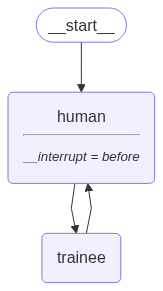

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [11]:
from langchain_core.messages import HumanMessage

def ask_question(question, config, graph):
    try:
        graph.update_state(
            config, {
                "messages": [HumanMessage(content=question, name="human")]
            },
            as_node="human",
        )
        
        print(f"✅ 質問を入力しました: {question}")
        
        events = graph.stream(None, config, stream_mode="values")
        
        has_trainee_response = False
        for event in events:
            # print(f"📦 Event: {event}")
            if "messages" in event and event["messages"]:
                last_msg = event["messages"][-1]
                # print(f"📝 Last message type: {type(last_msg)}")
                # print(f"📝 Last message name: {getattr(last_msg, 'name', 'None')}")
                
                if hasattr(last_msg, 'name') and last_msg.name == "trainee":
                    last_msg.pretty_print()
                    has_trainee_response = True
        
        if not has_trainee_response:
            print("❌ AI候補者からの回答がありませんでした")
            
            # 現在の状態を確認
            current_state = graph.get_state(config)
            print(f"📊 現在の状態: {current_state}")
            print(f"📊 次のノード: {current_state.next}")
        
    except Exception as e:
        print(f"エラー: {e}")
        import traceback
        traceback.print_exc()

In [12]:
import uuid
import time

question = "マイクロサービスの欠点は何ですか？"
config = {"configurable": {"thread_id": f"interview_{int(time.time())}_{str(uuid.uuid4())[:8]}"}}

ask_question(question, config, graph)

✅ 質問を入力しました: マイクロサービスの欠点は何ですか？
🤖 AI候補者が回答を生成中...
❓ 質問: マイクロサービスの欠点は何ですか？
✅ AI候補者の回答を生成しました
💬 回答: マイクロサービスアーキテクチャには、確かにいくつかの重要な欠点があります。私の経験を踏まえて、主な課題を説明します：

1. 複雑性の増大
マイクロサービスは、システム全体の運用複雑性を大幅に増加させます。以前、大規模な金融システムの再設計プロジェクトで、マイクロサービスへの移行を経験しましたが、サービス間の依存関係や通信の管理が非常に複雑になりました。

2. 分散システムの課題
- ネットワー...

🤖 AI候補者の回答:
================================== Ai Message ==================================
Name: trainee

マイクロサービスアーキテクチャには、確かにいくつかの重要な欠点があります。私の経験を踏まえて、主な課題を説明します：

1. 複雑性の増大
マイクロサービスは、システム全体の運用複雑性を大幅に増加させます。以前、大規模な金融システムの再設計プロジェクトで、マイクロサービスへの移行を経験しましたが、サービス間の依存関係や通信の管理が非常に複雑になりました。

2. 分散システムの課題
- ネットワーク遅延：サービス間の通信によるパフォーマンスオーバーヘッド
- 分散トランザクションの難しさ
- サービス間の一貫性維持が困難

3. テストの複雑化
各マイクロサービスの個別テストに加えて、サービス間の統合テストが非常に難しくなります。私のチームでは、これに対処するために複雑な継続的インテグレーション（CI）パイプラインを構築する必要がありました。

4. 運用オーバーヘッド
- 多数のサービスの監視
- デプロイメントの管理
- ログの集中管理
- リソース管理の複雑さ

5. データ管理の課題
- サービス間のデータ一貫性
- 分散データベースの管理
- トランザクションの atomicity の確保

6. コスト増加
- インフラストラクチャのコスト増大
- 開発と運用に必要な人的リソースの増加

7. チーム間のコミュニケーション負荷
サービスの境界を明確に

In [13]:
question = "マイクロサービスを採用して失敗した経験はありますか？どのように対処しましたか？"
ask_question(question, config, graph)

✅ 質問を入力しました: マイクロサービスを採用して失敗した経験はありますか？どのように対処しましたか？
🤖 AI候補者が回答を生成中...
❓ 質問: マイクロサービスを採用して失敗した経験はありますか？どのように対処しましたか？
✅ AI候補者の回答を生成しました
💬 回答: はい、マイクロサービスの導入において、かつて大きな失敗を経験しました。具体的なケースをお話しします。

約5年前、私が勤めていた大手eコマース企業で、モノリシックなアプリケーションをマイクロサービスに移行するプロジェクトに携わりました。この経験から、マイクロサービス導入の難しさを痛感しました。

失敗の主な要因：

1. 性急な移行戦略
- 一度に全てのサービスを分解しようとした
- 段階的な移行...

🤖 AI候補者の回答:
================================== Ai Message ==================================
Name: trainee

はい、マイクロサービスの導入において、かつて大きな失敗を経験しました。具体的なケースをお話しします。

約5年前、私が勤めていた大手eコマース企業で、モノリシックなアプリケーションをマイクロサービスに移行するプロジェクトに携わりました。この経験から、マイクロサービス導入の難しさを痛感しました。

失敗の主な要因：

1. 性急な移行戦略
- 一度に全てのサービスを分解しようとした
- 段階的な移行計画が不十分
- システムの複雑性を過小評価

2. チームの準備不足
- マイクロサービスアーキテクチャに関する知識が不足
- 分散システムの設計スキルが未熟
- DevOpsプラクティスの理解が不十分

具体的な問題：
- サービス間の通信で深刻なパフォーマンス低下
- 障害伝播による全体システムの不安定化
- データ整合性の喪失
- デプロイメントの複雑化

対処方法：

1. 段階的なリファクタリング
- モノリスを小さな機能単位で徐々に分解
- ステランクル・ストラングラーパターンの採用
- 重要度の低いサービスから段階的に移行

2. チームのスキルアップ
- マイクロサービスに関する集中トレーニング
- 分散システム設計のワークショップ実施
- 外部コンサルタントの招へ